In [2]:
%%capture
!pip install category_encoders
!pip install catboost
!pip install optuna


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
d_code = pd.read_csv("속성_D_코드.csv")
h_code = pd.read_csv("속성_H_코드.csv")
l_code = pd.read_csv("속성_L_코드.csv")

d_code.set_index('속성 D 코드', inplace=True)
d_code = d_code.T.to_dict()
h_code.set_index('속성 H 코드', inplace=True)
h_code = h_code.T.to_dict()
l_code.set_index('속성 L 코드', inplace=True)
l_code = l_code.T.to_dict()

# Sort df_train by date
df_train['contents_open_dt'] = pd.to_datetime(df_train['contents_open_dt'])
df_train.sort_values(by='contents_open_dt', inplace=True)

In [5]:
def add_codes(df, d_code, h_code, l_code):
    
    # D section encoding 
    df['person_prefer_d_1_l'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 대분류코드'])
    df['person_prefer_d_1_m'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 중분류코드'])    
    df['person_prefer_d_1_s'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 소분류코드'])    
    df['person_prefer_d_1_n'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    
    df['person_prefer_d_2_l'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 대분류코드'])
    df['person_prefer_d_2_m'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 중분류코드'])    
    df['person_prefer_d_2_s'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 소분류코드'])    
    df['person_prefer_d_2_n'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    
    df['person_prefer_d_3_l'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 대분류코드'])
    df['person_prefer_d_3_m'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 중분류코드'])    
    df['person_prefer_d_3_s'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 소분류코드'])    
    df['person_prefer_d_3_n'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    
    df['contents_attribute_d_l'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 대분류코드'])
    df['contents_attribute_d_m'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 중분류코드'])    
    df['contents_attribute_d_s'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 소분류코드'])    
    df['contents_attribute_d_n'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    
    # H section encoding 
    df['person_prefer_h_1_l'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_1_m'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 중분류코드'])
    
    df['person_prefer_h_2_l'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_2_m'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 중분류코드'])    

    df['person_prefer_h_3_l'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_3_m'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 중분류코드'])   
    
    df['contents_attribute_h_l'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['contents_attribute_h_m'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 중분류코드'])   
    
    # L section encoding
    df['contents_attribute_l_l'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 대분류코드'])
    df['contents_attribute_l_m'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 중분류코드'])    
    df['contents_attribute_l_s'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 소분류코드'])    
    df['contents_attribute_l_n'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 세분류코드'])
   
    return df

df_train = add_codes(df_train, d_code, h_code, l_code)
df_test = add_codes(df_test, d_code, h_code, l_code)

# Drop unnecessary columns
df_train.drop(['id','person_rn','contents_rn'], axis=1, inplace=True)
df_test.drop(['id','person_rn','contents_rn'], axis=1, inplace=True)

# Drop columns with only one unique value
unique_cols = [col for col in df_train.columns if df_train[col].nunique() == 1]
df_train.drop(unique_cols, axis=1, inplace=True)
df_test.drop(unique_cols, axis=1, inplace=True)

## EDA

Text(0, 0.5, 'Count')

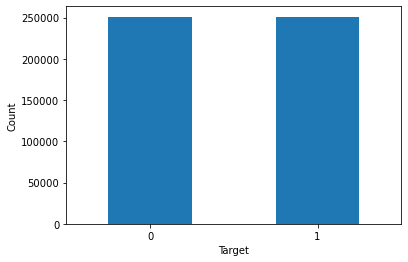

In [6]:
# Distribution of target
ax = df_train.target.value_counts().plot.bar(rot=0)
ax.set_xlabel('Target')
ax.set_ylabel('Count')

Almost same number of 0 and 1 targets

The PDF guide tells us that most of the answer codes on the surveys are non-ordinal, except for person_attribute_a_1, person_attribute_b, person_prefer_e and contents_attribute_e columns. First, let's see if the ordinality in these features is relevant to the target outcome.   

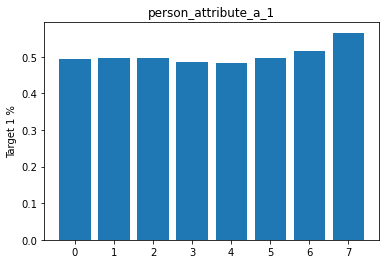

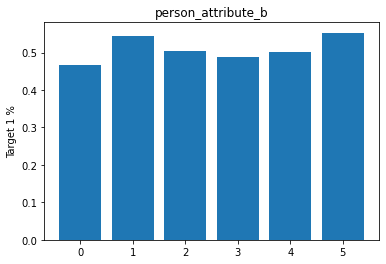

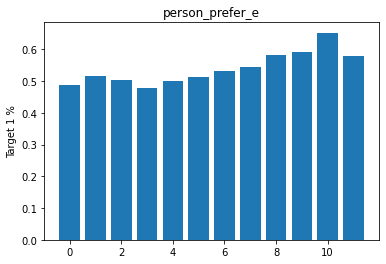

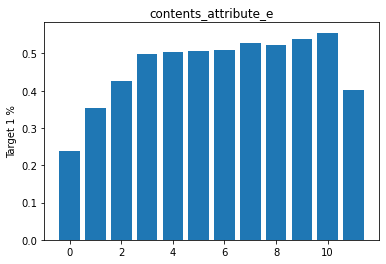

In [7]:
ordinal_cols = ['person_attribute_a_1', 'person_attribute_b', 'person_prefer_e', 'contents_attribute_e'] 

for col in ordinal_cols: 
    res = df_train.groupby([col])['target'].sum() / df_train.groupby([col])['target'].count()
    plt.bar(res.index, res)
    plt.title(col)
    plt.ylabel("Target 1 %")
    plt.show()

d_l_match_yn
0    0.407038
1    0.554633
Name: target, dtype: float64

d_m_match_yn
0    0.464081
1    0.598030
Name: target, dtype: float64

d_s_match_yn
0    0.481347
1    0.604024
Name: target, dtype: float64

h_l_match_yn
0    0.481011
1    0.504553
Name: target, dtype: float64

h_m_match_yn
0    0.498124
1    0.502553
Name: target, dtype: float64

h_s_match_yn
0    0.49781
1    0.50490
Name: target, dtype: float64

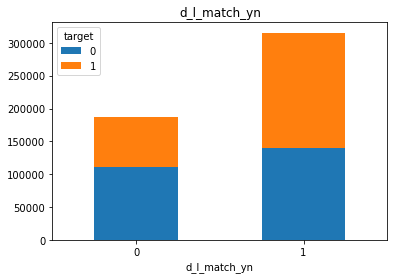

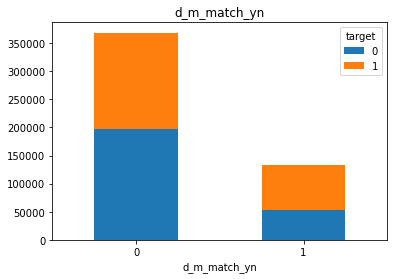

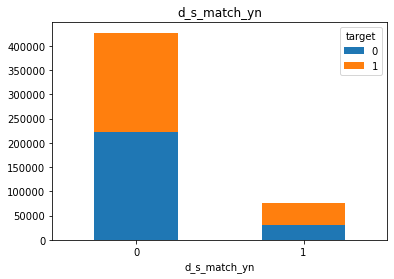

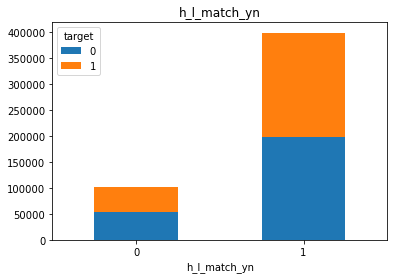

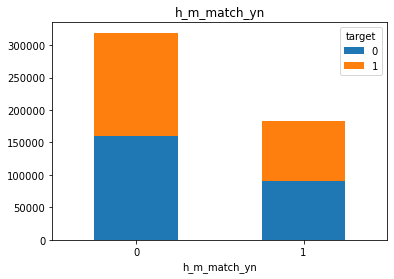

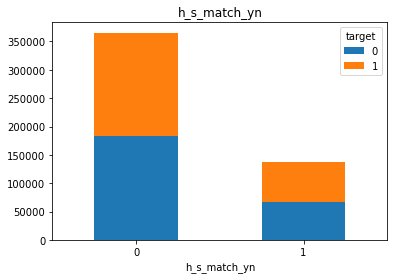

In [8]:
# Boolean columns 
bool_cols = ['d_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn', 'h_m_match_yn', 'h_s_match_yn']

df_train[bool_cols] = df_train[bool_cols].astype('int64')
df_test[bool_cols] = df_test[bool_cols].astype('int64')

# See boolean cols correlation to target
for col in bool_cols:
    ct = pd.crosstab(df_train[col], df_train['target'])
    ct.plot(kind='bar', stacked=True, rot=0)
    plt.title(col)
    plt.plot()

for col in bool_cols:
    res = df_train.groupby([col])['target'].sum() / df_train.groupby([col])['target'].count()
    display(res)



[]

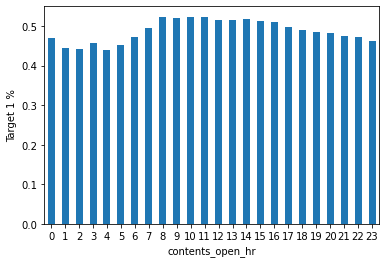

In [9]:
# Add content open hour column
df_train['contents_open_hr'] = pd.to_datetime(df_train.contents_open_dt).dt.hour
df_test['contents_open_hr'] = pd.to_datetime(df_test.contents_open_dt).dt.hour

# Drop contents open dt
df_train.drop(['contents_open_dt'], axis=1, inplace=True)
df_test.drop(['contents_open_dt'], axis=1, inplace=True)

# Conversion by hours
hourly = df_train.groupby(['contents_open_hr'])['target'].sum() / df_train.groupby(['contents_open_hr'])['target'].count()
hourly.plot.bar(rot=0)
plt.ylabel('Target 1 %')
plt.plot()



We can see that users are more likely to use the content during the daytime

In [10]:
# Onehot Encode cat columns with number of unique values < 5 and non ordinal
cat_cols_small = [col for col in df_train.columns if col not in bool_cols + ordinal_cols + ['target']
                  and df_train[col].nunique() < 6]
cat_cols_large = [col for col in df_train.columns if col not in bool_cols + ordinal_cols + ['target']
                  and df_train[col].nunique() >= 6]

In [11]:
"""
enc = OneHotEncoder(handle_unknown='ignore')
encoded = pd.DataFrame(enc.fit_transform(df_train[cat_cols_small]).toarray())
col_names = enc.get_feature_names_out()
df_train[col_names] = encoded

encoded = pd.DataFrame(enc.transform(df_test[cat_cols_small]).toarray())
col_names = enc.get_feature_names_out()
df_test[col_names] = encoded

df_train.drop(cat_cols_small, axis=1, inplace=True)
df_test.drop(cat_cols_small, axis=1, inplace=True)
"""

"\nenc = OneHotEncoder(handle_unknown='ignore')\nencoded = pd.DataFrame(enc.fit_transform(df_train[cat_cols_small]).toarray())\ncol_names = enc.get_feature_names_out()\ndf_train[col_names] = encoded\n\nencoded = pd.DataFrame(enc.transform(df_test[cat_cols_small]).toarray())\ncol_names = enc.get_feature_names_out()\ndf_test[col_names] = encoded\n\ndf_train.drop(cat_cols_small, axis=1, inplace=True)\ndf_test.drop(cat_cols_small, axis=1, inplace=True)\n"

In [12]:
"""
tmp = X_train[cat_cols_large].astype('str')
enc = ce.TargetEncoder(handle_unknown='value')
X_train[cat_cols_large] = enc.fit_transform(tmp, y_train)
X_test[cat_cols_large] = enc.transform(X_test[cat_cols_large].astype('str'))
"""

"\ntmp = X_train[cat_cols_large].astype('str')\nenc = ce.TargetEncoder(handle_unknown='value')\nX_train[cat_cols_large] = enc.fit_transform(tmp, y_train)\nX_test[cat_cols_large] = enc.transform(X_test[cat_cols_large].astype('str'))\n"

In [ ]:
# All non-boolean, non-ordinal columns
cat_cols_all = [col for col in df_train.columns if col not in bool_cols + ordinal_cols + ['target']]

for col in cat_cols_all:
    df_train[col] = df_train[col].astype('str')

fig, ax = plt.subplots(10,5, figsize=(,40))
for i,col in enumerate(cat_cols_all):
    res = df_train.groupby([col])['target'].sum() / df_train.groupby([col])['target'].count()
    ax[int(i/5)][int(i%5)].bar(res.index,res)
    ax[int(i/5)][int(i%5)].set_title(col)
fig.tight_layout(pad=3.0)
fig.show()


C:\Users\leeja\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


The plot above shows the ratio of target 1 & 0 for each variable in respective features. 
We can see that some of the features are highly correlated with the target, whereas others 
are not.

In [ ]:
# Columns to further remove - lack of target correlation
cols_remove = ['person_attribute_a','contents_attribute_a'
            ,'contents_attribute_i','contents_attribute_m']

df_train.drop(cols_remove, axis=1, inplace=True)
df_test.drop(cols_remove, axis=1, inplace=True)

In [ ]:
X_train = df_train.drop(['target'], axis=1)
y_train = df_train['target']
X_test = df_test.copy()

## Modeling

* Random Forest Classifier
* Logistic Regression
* SVC 
* XGB Classifier
* LDA
* Catboost Classifier

In [ ]:
# Train valid split - by date
X_train_new, X_valid = np.split(X_train, [int(0.9 *len(X_train))])
y_train_new, y_valid = np.split(y_train, [int(0.9 *len(y_train))])

# Standard Scaling 
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

X_train_new_scaled = pd.DataFrame(scaler.transform(X_train_new))



'\n# Standard Scaling \nscaler = StandardScaler()\n\nX_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))\nX_valid_scaled = pd.DataFrame(scaler.transform(X_valid))\nX_test_scaled = pd.DataFrame(scaler.transform(X_test))\n\nX_train_new_scaled = pd.DataFrame(scaler.transform(X_train_new))\n'

In [ ]:
"""
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, verbose=10)
rf.fit(X_train_new, y_train_new)
y_pred = rf.predict(X_valid)
"""

'\nrf = RandomForestClassifier(n_estimators=200, n_jobs=-1, verbose=10)\nrf.fit(X_train_new, y_train_new)\ny_pred = rf.predict(X_valid)\n'

In [ ]:
"""
params = {'n_estimators':[100,200,300], 'min_samples_split':[2,3,4]}
reg = RandomizedSearchCV(rf, params, n_iter=5, cv=5, scoring='f1', n_jobs=-1, verbose=10)
reg.fit(X_train_new_sampled, y_train_new_sampled)

y_pred = rf.predict(X_valid)
"""

"\nparams = {'n_estimators':[100,200,300], 'min_samples_split':[2,3,4]}\nreg = RandomizedSearchCV(rf, params, n_iter=5, cv=5, scoring='f1', n_jobs=-1, verbose=10)\nreg.fit(X_train_new_sampled, y_train_new_sampled)\n\ny_pred = rf.predict(X_valid)\n"

In [ ]:
"""
# Logistic Regression
log = LogisticRegression(n_jobs=-1, verbose=True)
log.fit(X_train_new_scaled, y_train_new)
y_pred = log.predict(X_valid_scaled)
"""

'\n# Logistic Regression\nlog = LogisticRegression(n_jobs=-1, verbose=True)\nlog.fit(X_train_new_scaled, y_train_new)\ny_pred = log.predict(X_valid_scaled)\n'

In [ ]:
"""
# Use PCA to reduce dimension 
pca = PCA(n_components=25)
X_train_reduced = pd.DataFrame(pca.fit_transform(X_train_scaled))
X_valid_reduced = pd.DataFrame(pca.transform(X_valid_scaled))
X_test_reduced = pd.DataFrame(pca.transform(X_test_scaled))

pca.explained_variance_ratio_.sum()
"""

'\n# Use PCA to reduce dimension \npca = PCA(n_components=25)\nX_train_reduced = pd.DataFrame(pca.fit_transform(X_train_scaled))\nX_valid_reduced = pd.DataFrame(pca.transform(X_valid_scaled))\nX_test_reduced = pd.DataFrame(pca.transform(X_test_scaled))\n\npca.explained_variance_ratio_.sum()\n'

In [ ]:
"""
svc = SVC(kernel='linear')
svc.fit(X_train_scaled_sampled, y_train_sampled)
y_pred = svc.predict(X_valid_scaled)
"""

"\nsvc = SVC(kernel='linear')\nsvc.fit(X_train_scaled_sampled, y_train_sampled)\ny_pred = svc.predict(X_valid_scaled)\n"

In [ ]:
"""
# XGB Classifier
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, early_stopping_rounds=5, n_jobs=-1, verbosity=3)
xgb.fit(X_train_new_scaled, y_train_new)
y_pred = xgb.predict(X_valid_scaled)
"""

'\n# XGB Classifier\nxgb = XGBClassifier(n_estimators=200, learning_rate=0.1, early_stopping_rounds=5, n_jobs=-1, verbosity=3)\nxgb.fit(X_train_new_scaled, y_train_new)\ny_pred = xgb.predict(X_valid_scaled)\n'

In [ ]:
"""
params = {'learning_rate':[0.01,0.1,0.2,0.3]}
reg = RandomizedSearchCV(xgb, params, n_iter=3, cv=5, scoring='f1', n_jobs=-1, verbose=10)
reg.fit(X_train_new_sampled, y_train_new_sampled)
reg.cv_results_
"""

"\nparams = {'learning_rate':[0.01,0.1,0.2,0.3]}\nreg = RandomizedSearchCV(xgb, params, n_iter=3, cv=5, scoring='f1', n_jobs=-1, verbose=10)\nreg.fit(X_train_new_sampled, y_train_new_sampled)\nreg.cv_results_\n"

In [ ]:
"""
# LDA
clf = LinearDiscriminantAnalysis()
clf.fit(X_train_new_scaled, y_train_new)
y_pred = clf.predict(X_valid_scaled)
"""

'\n# LDA\nclf = LinearDiscriminantAnalysis()\nclf.fit(X_train_new_scaled, y_train_new)\ny_pred = clf.predict(X_valid_scaled)\n'

In [ ]:
# Hyperparameter Tuning with Optuna
cat_features = [col for col in X_train.columns if X_train[col].nunique() > 2]

def objective(trial):
    
    param = {
        "objective": trial.suggest_categorical("objective", ["CrossEntropy","Logloss"]),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 3,9),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered","Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bernoulli","Bayesian","MVS"]
        ),
        #"used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.2, 0.4)

    model = CatBoostClassifier(iterations=1500, task_type='GPU', cat_features=cat_features, eval_metric='F1', **param)

    model.fit(X_train_new,y_train_new, eval_set=[(X_valid,y_valid)], verbose=100, early_stopping_rounds=100)

    proba_pred = model.predict_proba(X_valid)[:,1]
    y_pred = np.where(proba_pred > 0.4, 1, 0)

    f1 = f1_score(y_valid, y_pred)
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=3000)

[I 2022-01-09 02:24:04,595] A new study created in memory with name: no-name-9f9092bf-59fe-49b6-bf46-5b143475955d
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6149432	test: 0.6091376	best: 0.6091376 (0)	total: 425ms	remaining: 10m 36s
100:	learn: 0.6443543	test: 0.6355245	best: 0.6355245 (100)	total: 40.3s	remaining: 9m 18s
200:	learn: 0.6544510	test: 0.6389957	best: 0.6390245 (198)	total: 1m 17s	remaining: 8m 19s
300:	learn: 0.6599923	test: 0.6416365	best: 0.6418404 (285)	total: 1m 53s	remaining: 7m 31s
400:	learn: 0.6638454	test: 0.6419247	best: 0.6421869 (398)	total: 2m 28s	remaining: 6m 47s
500:	learn: 0.6670736	test: 0.6414427	best: 0.6422221 (445)	total: 3m 4s	remaining: 6m 6s
bestTest = 0.6422220533
bestIteration = 445
Shrink model to first 446 iterations.


[I 2022-01-09 02:27:38,187] Trial 0 finished with value: 0.6798243557889143 and parameters: {'objective': 'CrossEntropy', 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.1465067240707945}. Best is trial 0 with value: 0.6798243557889143.


Learning rate set to 0.035806
0:	learn: 0.6260208	test: 0.6188905	best: 0.6188905 (0)	total: 430ms	remaining: 10m 44s
100:	learn: 0.6483861	test: 0.6358138	best: 0.6367405 (92)	total: 42.4s	remaining: 9m 46s
200:	learn: 0.6593713	test: 0.6403016	best: 0.6403016 (200)	total: 1m 20s	remaining: 8m 40s
300:	learn: 0.6680079	test: 0.6387173	best: 0.6403016 (200)	total: 1m 58s	remaining: 7m 51s
bestTest = 0.6403016051
bestIteration = 200
Shrink model to first 201 iterations.


[I 2022-01-09 02:30:00,375] Trial 1 finished with value: 0.6788711381861131 and parameters: {'objective': 'Logloss', 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.22690774940257433}. Best is trial 0 with value: 0.6798243557889143.


0:	learn: 0.6032735	test: 0.5973628	best: 0.5973628 (0)	total: 279ms	remaining: 6m 57s
100:	learn: 0.6152436	test: 0.6099400	best: 0.6153208 (37)	total: 33.4s	remaining: 7m 43s
bestTest = 0.6153207915
bestIteration = 37
Shrink model to first 38 iterations.


[I 2022-01-09 02:30:59,780] Trial 2 finished with value: 0.6604819733318908 and parameters: {'objective': 'CrossEntropy', 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6798243557889143.


0:	learn: 0.6032735	test: 0.5973628	best: 0.5973628 (0)	total: 277ms	remaining: 6m 55s
100:	learn: 0.6094925	test: 0.6021936	best: 0.6108221 (33)	total: 31.9s	remaining: 7m 22s
bestTest = 0.6108221355
bestIteration = 33
Shrink model to first 34 iterations.


[I 2022-01-09 02:31:55,427] Trial 3 finished with value: 0.6581744400102122 and parameters: {'objective': 'CrossEntropy', 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6798243557889143.


0:	learn: 0.6304071	test: 0.6280418	best: 0.6280418 (0)	total: 381ms	remaining: 9m 31s
100:	learn: 0.6450371	test: 0.6360596	best: 0.6369465 (91)	total: 37s	remaining: 8m 33s
200:	learn: 0.6546641	test: 0.6385839	best: 0.6387359 (193)	total: 1m 10s	remaining: 7m 36s
300:	learn: 0.6606834	test: 0.6362225	best: 0.6387431 (202)	total: 1m 42s	remaining: 6m 50s
bestTest = 0.6387430557
bestIteration = 202
Shrink model to first 203 iterations.


[I 2022-01-09 02:33:53,131] Trial 4 finished with value: 0.6783993555283583 and parameters: {'objective': 'CrossEntropy', 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6000035041529983}. Best is trial 0 with value: 0.6798243557889143.


0:	learn: 0.6015616	test: 0.5991062	best: 0.5991062 (0)	total: 273ms	remaining: 6m 49s
100:	learn: 0.6360464	test: 0.6317547	best: 0.6317547 (100)	total: 28.7s	remaining: 6m 37s
200:	learn: 0.6429554	test: 0.6354763	best: 0.6359273 (185)	total: 57.3s	remaining: 6m 10s
300:	learn: 0.6463201	test: 0.6369648	best: 0.6372588 (287)	total: 1m 25s	remaining: 5m 42s
400:	learn: 0.6485787	test: 0.6376757	best: 0.6383719 (364)	total: 1m 54s	remaining: 5m 12s
500:	learn: 0.6508125	test: 0.6392620	best: 0.6394679 (490)	total: 2m 22s	remaining: 4m 44s
bestTest = 0.6394678996
bestIteration = 490
Shrink model to first 491 iterations.


[I 2022-01-09 02:36:56,440] Trial 5 finished with value: 0.677576979756457 and parameters: {'objective': 'CrossEntropy', 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.5326465061516354}. Best is trial 0 with value: 0.6798243557889143.


0:	learn: 0.6159229	test: 0.6094521	best: 0.6094521 (0)	total: 520ms	remaining: 12m 59s
100:	learn: 0.6400130	test: 0.6327111	best: 0.6327892 (99)	total: 43.7s	remaining: 10m 5s
200:	learn: 0.6485861	test: 0.6374577	best: 0.6382891 (193)	total: 1m 26s	remaining: 9m 17s
300:	learn: 0.6543611	test: 0.6379613	best: 0.6388104 (226)	total: 2m 9s	remaining: 8m 34s
bestTest = 0.6388103585
bestIteration = 226
Shrink model to first 227 iterations.


[I 2022-01-09 02:39:30,771] Trial 6 finished with value: 0.6765615905400851 and parameters: {'objective': 'CrossEntropy', 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6798243557889143.


0:	learn: 0.6286690	test: 0.6219632	best: 0.6219632 (0)	total: 1.31s	remaining: 32m 46s
100:	learn: 0.6487968	test: 0.6388061	best: 0.6392643 (97)	total: 1m 54s	remaining: 26m 24s
200:	learn: 0.6573866	test: 0.6389670	best: 0.6400135 (144)	total: 3m 37s	remaining: 23m 22s
bestTest = 0.6400134826
bestIteration = 144
Shrink model to first 145 iterations.


[I 2022-01-09 02:44:11,412] Trial 7 finished with value: 0.6769838856795378 and parameters: {'objective': 'CrossEntropy', 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.175945833221615}. Best is trial 0 with value: 0.6798243557889143.


Learning rate set to 0.035806
0:	learn: 0.6133010	test: 0.6080160	best: 0.6080160 (0)	total: 632ms	remaining: 15m 46s
100:	learn: 0.6428432	test: 0.6356681	best: 0.6361265 (96)	total: 52.7s	remaining: 12m 10s
200:	learn: 0.6523121	test: 0.6384052	best: 0.6387673 (189)	total: 1m 41s	remaining: 10m 56s
300:	learn: 0.6568874	test: 0.6377360	best: 0.6390101 (221)	total: 2m 30s	remaining: 10m
bestTest = 0.6390101067
bestIteration = 221
Shrink model to first 222 iterations.


[I 2022-01-09 02:47:06,552] Trial 8 finished with value: 0.6767026417774483 and parameters: {'objective': 'Logloss', 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6798243557889143.


Learning rate set to 0.035806
0:	learn: 0.6166370	test: 0.6083706	best: 0.6083706 (0)	total: 606ms	remaining: 15m 8s
100:	learn: 0.6468653	test: 0.6370442	best: 0.6370442 (100)	total: 60s	remaining: 13m 50s
200:	learn: 0.6567563	test: 0.6352796	best: 0.6374523 (133)	total: 1m 55s	remaining: 12m 28s
bestTest = 0.6374523063
bestIteration = 133
Shrink model to first 134 iterations.


[I 2022-01-09 02:49:34,446] Trial 9 finished with value: 0.6765171179750257 and parameters: {'objective': 'Logloss', 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.21848870687062066}. Best is trial 0 with value: 0.6798243557889143.


In [ ]:
cat_features = [col for col in X_train.columns if X_train[col].nunique() > 2]

model = CatBoostClassifier(iterations=1500, random_state=42, eval_metric='F1', task_type='GPU'
                            , cat_features=cat_features, one_hot_max_size=4, objective='Logloss', depth=10, boosting_type='Plain'
                            , bootstrap_type='Bernoulli', subsample=0.3)
model.fit(X_train_new, y_train_new, eval_set=(X_valid,y_valid), early_stopping_rounds=100, verbose=100)


Learning rate set to 0.035806
0:	learn: 0.6248271	test: 0.6134829	best: 0.6134829 (0)	total: 649ms	remaining: 16m 12s
100:	learn: 0.6583361	test: 0.6347968	best: 0.6349393 (97)	total: 55.4s	remaining: 12m 47s
200:	learn: 0.6735172	test: 0.6373127	best: 0.6376276 (199)	total: 1m 45s	remaining: 11m 21s
300:	learn: 0.6860114	test: 0.6383435	best: 0.6384902 (299)	total: 2m 35s	remaining: 10m 17s
400:	learn: 0.6957996	test: 0.6386723	best: 0.6389598 (317)	total: 3m 24s	remaining: 9m 20s
bestTest = 0.6389598238
bestIteration = 317
Shrink model to first 318 iterations.


In [ ]:
proba_pred = model.predict_proba(X_valid)[:,1]
y_pred = np.where(proba_pred > 0.3, 1, 0)

In [ ]:
f1_score(y_pred, y_valid)

0.6684078910808559

In [ ]:
submission = pd.DataFrame([X_test.index, y_pred]).T 
submission.columns = ['id','target']
submission.set_index('id', inplace=True)
submission
submission.to_csv('submission.csv')